In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from multiprocessing import Pool
import time
import os

In [2]:
# Set working directory
working_directory = "C:/FHWA_R2/Network"
os.chdir(working_directory)

# Define global variables
clean_data_folder = "CleanData"
raw_data_folder = "RawData"
hpms_folder = "RawData/HPMS2017"
spatial_data = "C:/FHWA_R2/spatial_boundary/CleanData"
demand_data = "C:/FHWA_R2/Demand/CleanData"
output_date = "2024"

In [3]:
# Functions
def read_geojson_df(filename):
    df = read_geojson(filename)
    df2 = pd.DataFrame.from_dict(df['features'])
    objects = [x for x in df2['properties']]
    object_df = pd.DataFrame.from_dict(objects)
    return object_df
    
def compile_state_data(hpms_folder,override=False):
    if os.path.exists("hpms.csv")&(override==False):
        return pd.read_csv("hpms.csv")
    else:
        # Read cleaned data from the sample
        hpms_files = [file for file in os.listdir(hpms_folder) if file.endswith(".geojson")]
        files_df = pd.DataFrame({"filename": hpms_files})
        files_df.to_csv("files.csv", index=False) 
        
        obs = len(files_df)
        
        # Prepare data files
        keep_cols = ["f_system","nhs", "through_la", "geoid", "aland", "awater", "urban_code", "length","lanemiles", "route_id", "psr", "state_code", "iri"]
        
        for i in range(obs):
            file_path = os.path.join(hpms_folder, files_df.iloc[i]["filename"])
            df = read_geojson_df(file_path)
            df.columns = df.columns.str.lower()
            these_cols = keep_cols.copy()
            these_cols.extend(df.columns[df.columns.str.contains('aadt')])
            these_cols.extend(df.columns[df.columns.str.contains('speed')])
            these_cols.extend(df.columns[df.columns.str.contains( "access_con")])
 
            # remove entries where link was merged to a diferent state (i.e., because it is on the border)
            df.drop(df.loc[df.state_code.astype(int)!=df.statefp.astype(int)].index,inplace=True)

            df = df[these_cols]
            df['state'] = files_df.iloc[i]["filename"].split('2017')[0]
            
            save_path = f"save{i}.csv" 
            df.to_csv(save_path, index=False)

        # Append files
        hpms_df = pd.read_csv("save0.csv") 
        for i in range(1, obs):
            save_path = f"save{i}.csv" 
            temp_df = pd.read_csv(save_path)
            hpms_df = pd.concat([hpms_df, temp_df], ignore_index=True)
        
        hpms_df.to_csv("hpms.csv", index=False)
        return hpms_df

In [4]:
# Load hpms data
over_ride = False # set to True if you want to reload and save the hpms data even if it already exists, else False
hpms_df = compile_state_data(hpms_folder,over_ride)

C:\Users\jrlazarus\AppData\Local\Temp\15\ipykernel_29236\2587672203.py:10: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv("hpms.csv")


In [15]:
hpms_df['check_len'] = (hpms_df['lanemiles']/(hpms_df['through_la']*0.00062137))-hpms_df['length']
hpms_df[['check_len','length']].describe()

,check_len,length
count,7.410784e+06,7.410784e+06
mean,9.909818e-04,2.250074e+02
std,3.104836e-03,7.049686e+02
min,1.553694e-15,3.527741e-10
25%,2.886124e-04,6.553088e+01
50%,7.038926e-04,1.598223e+02
75%,7.092849e-04,1.610467e+02
max,4.103837e-01,9.317967e+04


In [32]:
# VMT
# single-unit trucks (using AADT_Single_Unit), 
# combination trucks (using AADT_Combination), 
# light-duty vehicles (AADT - AADT_Single_Unit - AADT_Combination)
hpms_df['vmt_single_unit'] = hpms_df['aadt_singl']*hpms_df['length']*0.00062137
hpms_df['vmt_combi'] = hpms_df['aadt_combi']*hpms_df['length']*0.00062137
hpms_df['aadt_ldv'] = (hpms_df['aadt']-hpms_df['aadt_combi']-hpms_df['aadt_singl'])
hpms_df['vmt_ldv'] = (hpms_df['aadt_ldv'])*hpms_df['length']*0.00062137*(hpms_df['aadt_ldv']>0).astype(int)


In [33]:
hpms_df[['aadt_ldv','vmt_single_unit','vmt_combi','vmt_ldv']].describe()

,aadt_ldv,vmt_single_unit,vmt_combi,vmt_ldv
count,7.410784e+06,7.410784e+06,7.410784e+06,7.410784e+06
mean,1.161144e+04,3.115178e+01,5.454209e+01,9.306741e+02
std,2.257766e+04,9.060429e+01,1.801944e+02,2.104510e+03
min,-2.091320e+05,0.000000e+00,0.000000e+00,-0.000000e+00
25%,1.569000e+03,0.000000e+00,0.000000e+00,8.895249e+01
50%,4.600000e+03,5.941865e+00,4.097947e+00,2.952592e+02
75%,1.240000e+04,2.787927e+01,2.827424e+01,8.946174e+02
max,4.301430e+05,8.279186e+04,7.929575e+04,4.748364e+05


In [35]:
hpms_df.loc[hpms_df.aadt_ldv <0, ['f_system', 'nhs', 'through_la', 'length','geoid',
       'urban_code','aadt','aadt_singl','aadt_combi','aadt_ldv','vmt_ldv']].head()

,f_system,nhs,through_la,length,geoid,urban_code,aadt,aadt_singl,aadt_combi,aadt_ldv,vmt_ldv
426659,3.0,0.0,2.0,160.886934,6111009500,79282.0,610.0,1021.0,21.0,-432.0,-0.0
426661,3.0,0.0,2.0,40.454998,6111009500,79282.0,610.0,1021.0,21.0,-432.0,-0.0
426674,3.0,0.0,2.0,117.850273,6111009500,79282.0,610.0,1021.0,21.0,-432.0,-0.0
431294,1.0,1.0,2.0,1.558373,6073017022,78661.0,0.0,65.0,169.0,-234.0,-0.0
431296,1.0,1.0,2.0,1512.819922,6073017022,78661.0,0.0,4252.0,4074.0,-8326.0,-0.0


<Axes: title={'center': 'vmt_single_unit'}, xlabel='f_system'>

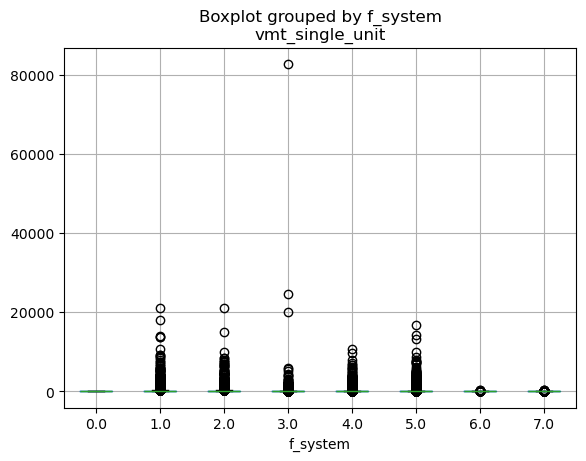

In [36]:
hpms_df[['f_system','vmt_single_unit']].boxplot('vmt_single_unit',by='f_system')

<Axes: title={'center': 'vmt_combi'}, xlabel='f_system'>

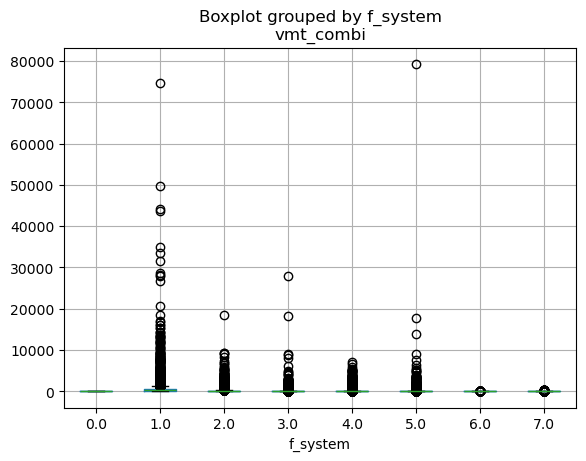

In [37]:
hpms_df[['f_system','vmt_combi']].boxplot('vmt_combi',by='f_system')

<Axes: title={'center': 'vmt_ldv'}, xlabel='f_system'>

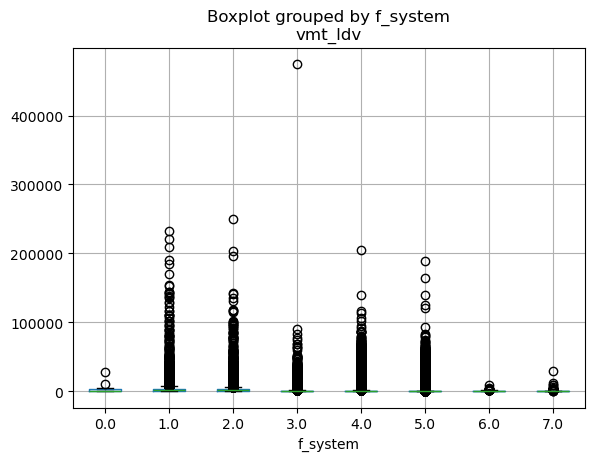

In [38]:
hpms_df[['f_system','vmt_ldv']].boxplot('vmt_ldv',by='f_system')

In [43]:
for f in [1,2,3,4,5,6,7]:
    for c in ['vmt_single_unit', 'vmt_combi', 'vmt_ldv']:
        hpms_df[f'{c}_f{f}'] = hpms_df[f'{c}']*(hpms_df['f_system']==f).astype(int)
hpms_df.columns

Index(['f_system', 'nhs', 'through_la', 'geoid', 'aland', 'awater',
       'urban_code', 'length', 'lanemiles', 'route_id', 'psr', 'state_code',
       'iri', 'aadt', 'aadt_singl', 'aadt_combi', 'speed_limi', 'access_con',
       'state', 'vmt_single_unit', 'vmt_combi', 'vmt_ldv', 'check_len',
       'aadt_ldv', 'vmt_single_unit_f1', 'vmt_combi_f1', 'vmt_ldv_f1',
       'vmt_single_unit_f2', 'vmt_combi_f2', 'vmt_ldv_f2',
       'vmt_single_unit_f3', 'vmt_combi_f3', 'vmt_ldv_f3',
       'vmt_single_unit_f4', 'vmt_combi_f4', 'vmt_ldv_f4',
       'vmt_single_unit_f5', 'vmt_combi_f5', 'vmt_ldv_f5',
       'vmt_single_unit_f6', 'vmt_combi_f6', 'vmt_ldv_f6',
       'vmt_single_unit_f7', 'vmt_combi_f7', 'vmt_ldv_f7'],
      dtype='object')

In [44]:
print(hpms_df.shape)
final_df = hpms_df.rename(columns={'geoid': 'tract'})[['tract','state','vmt_single_unit', 'vmt_combi', 'vmt_ldv','vmt_single_unit_f1', 'vmt_combi_f1', 'vmt_ldv_f1',
       'vmt_single_unit_f2', 'vmt_combi_f2', 'vmt_ldv_f2',
       'vmt_single_unit_f3', 'vmt_combi_f3', 'vmt_ldv_f3',
       'vmt_single_unit_f4', 'vmt_combi_f4', 'vmt_ldv_f4',
       'vmt_single_unit_f5', 'vmt_combi_f5', 'vmt_ldv_f5',
       'vmt_single_unit_f6', 'vmt_combi_f6', 'vmt_ldv_f6',
       'vmt_single_unit_f7', 'vmt_combi_f7', 'vmt_ldv_f7']].groupby(
    ['tract', 'state']).sum().reset_index()
final_df.shape

(7410784, 45)


(83612, 26)

In [46]:
final_df.to_csv(f'{clean_data_folder}/hpms_vmt_f_system.csv')